In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('omw-1.4')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
analyzer = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to C:\Users\Fuzel
[nltk_data]     Shaik\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from tabulate import tabulate
import pyLDAvis
import pyLDAvis.gensim_models as genismnvis 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

C:\Users\Fuzel Shaik\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
import spacy
stop_words.extend(['from', 'use'])
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [7]:
topicsname=[]
num_topics =10
bigramDataWords = []
trigramDataWords = []
appDetailInputsForLDA =[]
ldaModelDetailsTfAppWise =[]
ldaModelDetailsTfIdfAppWise =[]

#function for preprocessing Data
def PreProcessReviewData(reviewData):
    for review in reviewData:
        yield gensim.utils.simple_preprocess(str(review), deacc=True, min_len=2)  # deacc=True removes punctuations

#function for removing stopwords
def removeStopWords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#function for bigram creation 
def make_bigrams(texts):
    for doc in texts:
        x = bigram_mod[doc]
        bigramDataWords.append(x)
    return bigramDataWords

#function for trigram creation 
def make_trigrams(texts):
    for doc in texts:
        y = trigram_mod[bigram_mod[doc]]
        trigramDataWords.append(y)
    return trigramDataWords

#function for lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#function for training LDA model with Tf corpus
def TrainLdaModelWithTf(corpus, id2word, topics = 10, passes= 10, iterations =50) :
    ldaModel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=topics,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=passes,
                                            alpha='auto',
                                            per_word_topics=True,
                                            iterations=iterations)
    return ldaModel

#function for training LDA model with TfIdf corpus
def TrainLdaModelWithTfIdf(corpus, id2word, topics = 10, passes= 10, iterations =50) :
    ldaModel = gensim.models.LdaMulticore(corpus=corpus,
                                            id2word=id2word,
                                            num_topics= topics,
                                            random_state=100,
                                            chunksize=100,
                                            passes=passes,
                                            per_word_topics=True,
                                            iterations= iterations)
    return ldaModel

#function for evaluate LDA model
def EvaluatePerformance(corpus, ldaModel, corpusType):
    results =[corpusType]
    perplexity = ldaModel.log_perplexity(corpus)

    # Compute CV Coherence Score
    cvCoherenceModel = CoherenceModel(model=ldaModel, texts=lemmatizedData, dictionary=id2word, coherence='c_v')
    cvCoherence = cvCoherenceModel.get_coherence()

    # Compute umass Coherence Score
    uMassCoherenceModel = CoherenceModel(model=ldaModel, texts=lemmatizedData, dictionary=id2word, coherence='u_mass')
    uMassCoherence = uMassCoherenceModel.get_coherence()

    results.append(perplexity)
    results.append(cvCoherence)
    results.append(uMassCoherence)

    return results

#function for printing words in the topic
def PrintTopicWords(wordSet):
    topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in wordSet]
    for topic,words in topics_words:
        print(str(topic)+ "::"+ str(words))

#function for plpting LDA model generated topics
def PlottingResults(ldamodel, corpus, id2word):
    pyLDAvis.enable_notebook()
    vis = genismnvis.prepare(ldamodel, corpus, id2word)
    return vis

In [8]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True,
                                            iterations=50)
                                            
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [9]:
def PlotCoherenceValueAgainstNumofTopics(appName, model, coherence_values):
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.title(appName)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score "+ model)
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [6]:
apps = ['C:\\Users\\Fuzel Shaik\\Documents\\Master Thesis\\Data_extraction\\emergency_sentiment.csv','C:\\Users\\Fuzel Shaik\\Documents\\Master Thesis\\Data_extraction\\suomi_sentiment.csv','C:\\Users\\Fuzel Shaik\\Documents\\Master Thesis\\Data_extraction\\sos_sentiment.csv']

df_emp = pd.read_csv(apps[0])
df_pos_emp = df_emp[df_emp['Sentiment']==1]
df_neg_emp = df_emp[df_emp['Sentiment']==-1]

df_suomi = pd.read_csv(apps[1])
df_pos_suomi = df_suomi[df_suomi['Sentiment']==1]
df_neg_suomi = df_suomi[df_suomi['Sentiment']==-1]

df_sos = pd.read_csv(apps[2])
df_pos_sos = df_sos[df_sos['Sentiment']==1]
df_neg_sos = df_sos[df_sos['Sentiment']==-1]

In [10]:
df_pos_reviews = pd.concat([df_pos_emp,df_pos_suomi,df_pos_sos])
df_neg_reviews = pd.concat([df_neg_emp,df_neg_suomi,df_neg_sos])

In [9]:
apps = [df_pos_reviews,df_neg_reviews]

for i in range(len(apps)):
    df = apps[i].copy()
    reviewDataList = df['Review'].values.tolist()

In [11]:
apps = [df_pos_reviews,df_neg_reviews]

for i in range(len(apps)):
    EvaluationResults =[]
    df = apps[i].copy()
    reviewDataList = df['Review'].values.tolist()

  #preprocessing using genism simple pre process
    reviewDataWords = list(PreProcessReviewData(reviewDataList))

  #stopword removal using nltk stop words
    reviewDataWordsWithoutStopWords = removeStopWords(reviewDataWords)

  # bigram trigram models
    bigram = gensim.models.Phrases(reviewDataWords, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[reviewDataWords], threshold=100)

    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
  
  #creating bigram trigram models from the data set
    dataWordsWithbigrams = make_bigrams(reviewDataWordsWithoutStopWords)
    dataWordsWithTrigrams = make_trigrams(dataWordsWithbigrams)

  #lemmatizing data set
    lemmatizedData = lemmatization(dataWordsWithTrigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
 
  #create dictionary as the input for lda model
    id2word = corpora.Dictionary(lemmatizedData)
    
    # Create Corpus
    texts = lemmatizedData

  # create corpus with Term Document Frequency
    corpusTf = [id2word.doc2bow(text) for text in texts]

  #create corpus with tf-idf
    tfidf = gensim.models.TfidfModel(corpusTf)
    corpusTfidf = tfidf[corpusTf]
  
  #store details in dictionary for use later for evaluation
    dictionary = {'appName':apps[i],'id2word':id2word, 'lemmatized': lemmatizedData, 'tf' : corpusTf, 'tfIdf': corpusTfidf }
    appDetailInputsForLDA.append(dictionary)

    ldaModelTfIdfDetails =[]
    
    ldaModelTfIdf = TrainLdaModelWithTfIdf(corpusTfidf, id2word)
    ldaModelTIdffWords = ldaModelTfIdf.show_topics(num_topics=10, num_words=10,formatted=False)
    print("\n 10 Topics obtained from the reviews of "+str(i)+ " - TfIdf Corpus")
    PrintTopicWords(ldaModelTIdffWords) #Fig. 6 in report displays this result
  #pprint(ldaModelTfIdf.print_topics()) -print with probabilities
    results = EvaluatePerformance(corpusTfidf, ldaModelTfIdf, corpusType = 'TF-IDF')
    EvaluationResults.append(results)
  
  #Store details to utilize when plotting graphs
    ldaModelTfIdfDetails.append(ldaModelTfIdf)
    ldaModelTfIdfDetails.append(corpusTfidf)
    ldaModelTfIdfDetails.append(id2word)
    ldaModelDetailsTfIdfAppWise.append(ldaModelTfIdfDetails)
    print('Evaluation table '+str(i)+'------------')
    print (tabulate(EvaluationResults, headers=["Corpus Type", "Perplexity", "Cv coherence score", "U mass Coherence score"]))


 10 Topics obtained from the reviews of 0 - TfIdf Corpus
0::['important', 'really', 'good', 'app', 'thing', 'know', 'application', 'useful', 'phone', 'brilliant']
1::['good', 'app', 'emergency', 'application', 'idea', 'battery', 'hopefully', 'use', 'far', 'job']
2::['awesome', 'useful', 'well', 'life', 'save', 'work', 'nice', 'app', 'download', 'notification']
3::['safe', 'number', 'phone', 'good', 'location', 'would', 'great', 'app', 'really', 'call']
4::['necessary', 'worth', 'work', 'fantastic', 'good', 'service', 'app', 'call', 'great', 'case']
5::['excellent', 'hope', 'never', 'app', 'need', 'recommend', 'sure', 'love', 'mandatory', 'time']
6::['easy', 'security', 'make', 'sense', 'call', 'fast', 'app', 'location', 'emergency', 'help']
7::['great', 'app', 'invention', 'idea', 'work', 'emergency', 'find', 'must', 'really', 'would']
8::['smart', 'helpful', 'app', 'need', 'nice', 'application', 'good', 'would', 'phone', 'otherwise']
9::['thank', 'need', 'look', 'good', 'app', 'work'

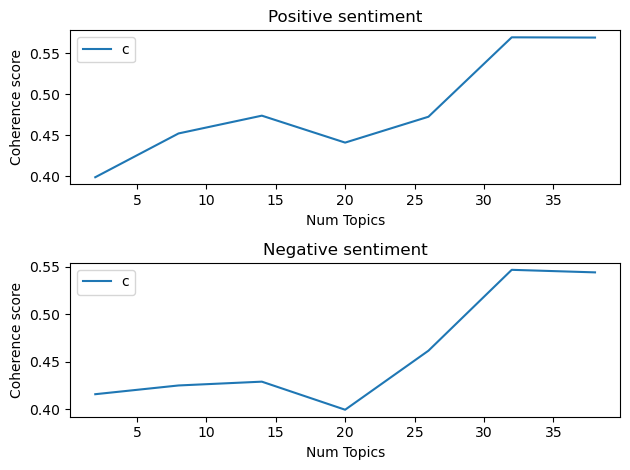

In [16]:
fig, axs = plt.subplots(2)
limit=40; start=2; step=6;
x = range(start, limit, step)
#model_list, coherence_values = compute_coherence_values(dictionary=appDetailInputsForLDA[0]['id2word'], corpus=appDetailInputsForLDA[0]['tf'], texts=appDetailInputsForLDA[0]['lemmatized'], start=2, limit=40, step=6)
#PlotCoherenceValueAgainstNumofTopics("Positive sentiment", "tf model", coherence_values)


#axs[0,0].plot(x, coherence_values)
#axs[0,0].set_title("Positive sentiment")
#axs[0,0].legend(("coherence_values"), loc='best')
#plt.xlabel("Num Topics")
#plt.ylabel("Coherence score "+ "tf model")
#plt.legend(("coherence_values"), loc='best')
#plt.show()

model_list, coherence_values = compute_coherence_values(dictionary=appDetailInputsForLDA[0]['id2word'], corpus=appDetailInputsForLDA[0]['tfIdf'], texts=appDetailInputsForLDA[0]['lemmatized'], start=2, limit=40, step=6)
#PlotCoherenceValueAgainstNumofTopics("Positive sentiment", "tf-idf model", coherence_values)

axs[0].plot(x, coherence_values)
axs[0].set_title("Positive sentiment")
axs[0].legend(("coherence_values"), loc='best')
axs[0].set_xlabel('Num Topics')
axs[0].set_ylabel('Coherence score')

#model_list, coherence_values = compute_coherence_values(dictionary=appDetailInputsForLDA[1]['id2word'], corpus=appDetailInputsForLDA[1]['tf'], texts=appDetailInputsForLDA[0]['lemmatized'], start=2, limit=40, step=6)
#PlotCoherenceValueAgainstNumofTopics("Negative sentiment", "tf model", coherence_values)

#axs[1,0].plot(x, coherence_values)
#axs[1,0].set_title("Negative sentiment")
#axs[1,0].legend(("coherence_values"), loc='best')

model_list, coherence_values = compute_coherence_values(dictionary=appDetailInputsForLDA[1]['id2word'], corpus=appDetailInputsForLDA[1]['tfIdf'], texts=appDetailInputsForLDA[1]['lemmatized'], start=2, limit=40, step=6)
#PlotCoherenceValueAgainstNumofTopics("Negative sentiment", "tf-idf model", coherence_values)

axs[1].plot(x, coherence_values)
axs[1].set_title("Negative sentiment")
axs[1].legend(("coherence_values"), loc='best')
axs[1].set_xlabel('Num Topics')
axs[1].set_ylabel('Coherence score')

fig.tight_layout()

In [13]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [40]:
topicsname=[]
bigramDataWords = []
trigramDataWords = []
appDetailInputsForLDA =[]
ldaModelDetailsTfAppWise =[]
ldaModelDetailsTfIdfAppWise =[]

In [41]:
apps = [df_pos_reviews]

for i in range(len(apps)):
    EvaluationResults =[]
    df = apps[i].copy()
    reviewDataList = df['Review'].values.tolist()
    
    numberofTfIdfTopics=5

  #preprocessing using genism simple pre process
    reviewDataWords = list(PreProcessReviewData(reviewDataList))

  #stopword removal using nltk stop words
    reviewDataWordsWithoutStopWords = removeStopWords(reviewDataWords)

  # bigram trigram models
    bigram = gensim.models.Phrases(reviewDataWords, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[reviewDataWords], threshold=100)

    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
  
  #creating bigram trigram models from the data set
    dataWordsWithbigrams = make_bigrams(reviewDataWordsWithoutStopWords)
    dataWordsWithTrigrams = make_trigrams(dataWordsWithbigrams)

  #lemmatizing data set
    lemmatizedData = lemmatization(dataWordsWithTrigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
 
  #create dictionary as the input for lda model
    id2word = corpora.Dictionary(lemmatizedData)
    
    # Create Corpus
    texts = lemmatizedData

  # create corpus with Term Document Frequency
    corpusTf = [id2word.doc2bow(text) for text in texts]

  #create corpus with tf-idf
    tfidf = gensim.models.TfidfModel(corpusTf)
    corpusTfidf = tfidf[corpusTf]
  
  #store details in dictionary for use later for evaluation
    dictionary = {'appName':apps[i],'id2word':id2word, 'lemmatized': lemmatizedData, 'tf' : corpusTf, 'tfIdf': corpusTfidf }
    appDetailInputsForLDA.append(dictionary)

    ldaModelTfIdfDetails =[]
    
    ldaModelTfIdf = TrainLdaModelWithTfIdf(corpusTfidf, id2word, topics=numberofTfIdfTopics, passes=20)
    ldaModelTIdffWords = ldaModelTfIdf.show_topics(num_topics=numberofTfIdfTopics, num_words=10,formatted=False)
    print("\nTopics obtained from the reviews of "+str(i)+ " - TfIdf Corpus")
    PrintTopicWords(ldaModelTIdffWords) #Fig. 6 in report displays this result
  #pprint(ldaModelTfIdf.print_topics()) -print with probabilities
    results = EvaluatePerformance(corpusTfidf, ldaModelTfIdf, corpusType = 'TF-IDF')
    EvaluationResults.append(results)
  
  #Store details to utilize when plotting graphs
    ldaModelTfIdfDetails.append(ldaModelTfIdf)
    ldaModelTfIdfDetails.append(corpusTfidf)
    ldaModelTfIdfDetails.append(id2word)
    ldaModelDetailsTfIdfAppWise.append(ldaModelTfIdfDetails)
    print (tabulate(EvaluationResults, headers=["Corpus Type", "Perplexity", "Cv coherence score", "U mass Coherence score"]))


Topics obtained from the reviews of 0 - TfIdf Corpus
0::['really', 'important', 'good', 'application', 'app', 'phone', 'open', 'crash', 'brilliant', 'would']
1::['good', 'great', 'app', 'excellent', 'emergency', 'idea', 'thank', 'battery', 'work', 'situation']
2::['awesome', 'useful', 'well', 'work', 'nice', 'life', 'necessary', 'save', 'app', 'recommend']
3::['safe', 'easy', 'need', 'good', 'number', 'never', 'thing', 'help', 'phone', 'app']
4::['app', 'find', 'download', 'great', 'location', 'help', 'work', 'service', 'worth', 'call']
Corpus Type      Perplexity    Cv coherence score    U mass Coherence score
-------------  ------------  --------------------  ------------------------
TF-IDF             -8.36716              0.378767                  -5.50808


Topic 1: Reliability
Topic 2: Necessity
Topic 3: Accurate awareness
Topic 4: Compatability
Topic 5: Usability 

In [42]:
vis =PlottingResults(ldaModelDetailsTfIdfAppWise[0][0], ldaModelDetailsTfIdfAppWise[0][1], ldaModelDetailsTfIdfAppWise[0][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.028343 -0.009713       1        1  23.783614
0      0.021527 -0.062323       2        1  21.852827
4      0.027562  0.002063       3        1  18.426397
1     -0.097399 -0.001388       4        1  18.302636
2      0.019968  0.071361       5        1  17.634526, topic_info=             Term       Freq      Total Category  logprob  loglift
7            good  85.000000  85.000000  Default  30.0000  30.0000
203     important  25.000000  25.000000  Default  29.0000  29.0000
26      excellent  12.000000  12.000000  Default  28.0000  28.0000
125        really  26.000000  26.000000  Default  27.0000  27.0000
117       awesome  11.000000  11.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
893   application   2.546656  20.630665   Topic5  -5.5157  -0.3567
7            good   3.575576  85.977829   Topic5  -5.1763  -1.4447
118         phone   2.423119  19.741611   Topic5  -5.5654  -0.3624
1001      battery   2.080730  10.277595   Topic5  -5.7177   0.1381
139           use   2.048988   9.534403   Topic5  -5.7331   0.1978

[320 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
772       3  0.540162  absolutely
772       5  0.270081  absolutely
54        5  0.523355  accessible
755       1  0.301444    accuracy
755       2  0.602888    accuracy
...     ...       ...         ...
24        1  0.223914       would
24        2  0.279892       would
24        3  0.167935       would
24        4  0.111957       would
24        5  0.167935       would

[520 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 2, 3])

In [43]:
df_topic_sents_keywords_pos = format_topics_sentences(ldamodel=ldaModelTfIdf, corpus=corpusTfidf, texts=lemmatizedData)

In [92]:
df_dominant_topic_pos = df_topic_sents_keywords_pos.reset_index()
df_dominant_topic_pos.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_pos.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.8515,"really, important, good, application, app, pho...","[latitude, longitude, correct, notice, address..."
1,1,2,0.5976,"awesome, useful, well, work, nice, life, neces...",[must]
2,2,1,0.6000,"good, great, app, excellent, emergency, idea, ...",[excellent]
3,3,3,0.7822,"safe, easy, need, good, number, never, thing, ...","[set, address, incorrectly, even, marker, clea..."
4,4,3,0.7009,"safe, easy, need, good, number, never, thing, ...","[location, always, wrong, location]"
5,5,3,0.7768,"safe, easy, need, good, number, never, thing, ...","[never, yet, would, number, app, would, incase..."
6,6,2,0.7935,"awesome, useful, well, work, nice, life, neces...","[instal, app, check, location, live, estate, n..."
7,7,1,0.6349,"good, great, app, excellent, emergency, idea, ...","[good, experience]"
8,8,4,0.6650,"app, find, download, great, location, help, wo...","[fantastic, technology]"
9,9,1,0.6496,"good, great, app, excellent, emergency, idea, ...","[good, thank]"


In [45]:
df_dominant_topic_pos['Dominant_Topic_name'] = df_dominant_topic_pos['Dominant_Topic'].replace([0,1,2,3,4],
                        ['Reliability','Necessity','Accurate awareness','Compatability','Usability'])

In [46]:
df_dominant_topic_pos.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Dominant_Topic_name
0,0,0,0.8515,"really, important, good, application, app, pho...","[latitude, longitude, correct, notice, address...",Reliability
1,1,2,0.5976,"awesome, useful, well, work, nice, life, neces...",[must],Accurate awareness
2,2,1,0.6000,"good, great, app, excellent, emergency, idea, ...",[excellent],Necessity
3,3,3,0.7822,"safe, easy, need, good, number, never, thing, ...","[set, address, incorrectly, even, marker, clea...",Compatability
4,4,3,0.7009,"safe, easy, need, good, number, never, thing, ...","[location, always, wrong, location]",Compatability
5,5,3,0.7768,"safe, easy, need, good, number, never, thing, ...","[never, yet, would, number, app, would, incase...",Compatability
6,6,2,0.7935,"awesome, useful, well, work, nice, life, neces...","[instal, app, check, location, live, estate, n...",Accurate awareness
7,7,1,0.6349,"good, great, app, excellent, emergency, idea, ...","[good, experience]",Necessity
8,8,4,0.6650,"app, find, download, great, location, help, wo...","[fantastic, technology]",Usability
9,9,1,0.6496,"good, great, app, excellent, emergency, idea, ...","[good, thank]",Necessity


In [47]:
temp_df = pd.DataFrame(df_dominant_topic_pos['Dominant_Topic_name'].value_counts()).reset_index()

In [52]:
temp_df.columns = ['Dominant_Topic_name','Frequency']

In [60]:
temp_df.head()

,Dominant_Topic_name,Frequency,dominant_topic_percentage
0,Reliability,349,23.74
1,Necessity,331,22.52
2,Compatability,324,22.04
3,Accurate awareness,243,16.53
4,Usability,223,15.17


In [59]:
temp_df['dominant_topic_percentage'] = round((temp_df['Frequency']/temp_df['Frequency'].sum())*100,2)

<BarContainer object of 5 artists>

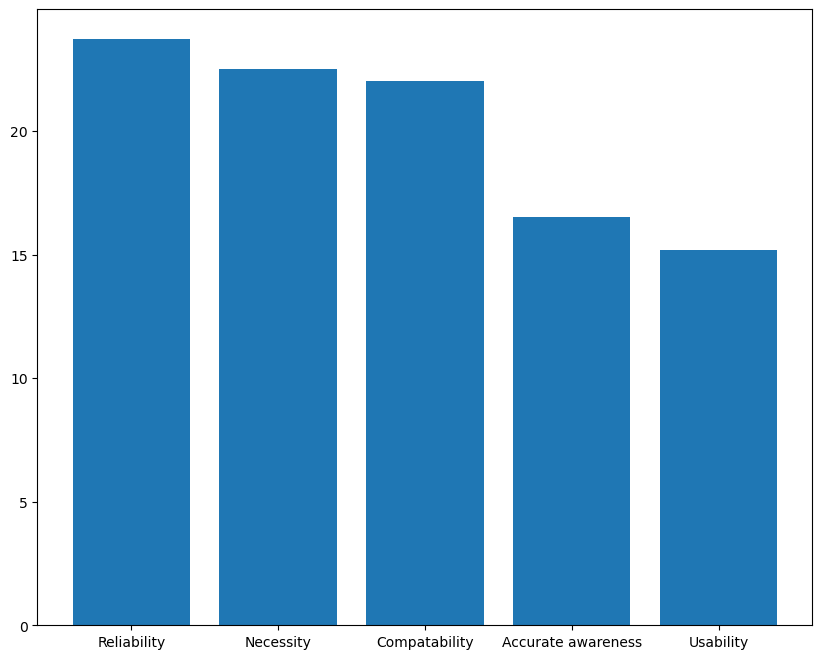

In [63]:
plt.figure(figsize=(10,8))
plt.bar(temp_df['Dominant_Topic_name'],temp_df['dominant_topic_percentage'])

topic score for a positive sentiment = (1/number of reviews for positive sentiment * sigma(probability of that review belongs to that topic in positive sentiment))/(1/number of total reviews * sigma(probability of that review belongs to that topic in whole dataframe))

In [76]:
number_of_reviews_for_positive_sentiment = df_pos_reviews.shape[0]
number_of_total_reviews = pd.concat([df_pos_reviews,df_neg_reviews]).shape[0]
prob_topic_2_in_pos_reviews = df_dominant_topic_pos[df_dominant_topic_pos['Dominant_Topic']==2].shape[0]/df_dominant_topic_pos.shape[0]
df_dominant_topic = pd.concat([df_dominant_topic_pos,df_dominant_topic_neg])
prob_topic_2_in_whole_reviews = df_dominant_topic[df_dominant_topic['Dominant_Topic']==2].shape[0]/df_dominant_topic.shape[0]
topic_2_score_pos_reviews = ((1/number_of_reviews_for_positive_sentiment)*prob_topic_2_in_pos_reviews)/((1/number_of_total_reviews)*prob_topic_2_in_whole_reviews)

In [77]:
topic_2_score_pos_reviews

1.4762861170482995

In [70]:
topicsname=[]
bigramDataWords = []
trigramDataWords = []
appDetailInputsForLDA =[]
ldaModelDetailsTfAppWise =[]
ldaModelDetailsTfIdfAppWise =[]

In [71]:
apps = [df_neg_reviews]

for i in range(len(apps)):
    EvaluationResults =[]
    df = apps[i].copy()
    reviewDataList = df['Review'].values.tolist()
    
    numberofTfIdfTopics=5

  #preprocessing using genism simple pre process
    reviewDataWords = list(PreProcessReviewData(reviewDataList))

  #stopword removal using nltk stop words
    reviewDataWordsWithoutStopWords = removeStopWords(reviewDataWords)

  # bigram trigram models
    bigram = gensim.models.Phrases(reviewDataWords, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[reviewDataWords], threshold=100)

    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
  
  #creating bigram trigram models from the data set
    dataWordsWithbigrams = make_bigrams(reviewDataWordsWithoutStopWords)
    dataWordsWithTrigrams = make_trigrams(dataWordsWithbigrams)

  #lemmatizing data set
    lemmatizedData = lemmatization(dataWordsWithTrigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
 
  #create dictionary as the input for lda model
    id2word = corpora.Dictionary(lemmatizedData)
    
    # Create Corpus
    texts = lemmatizedData

  # create corpus with Term Document Frequency
    corpusTf = [id2word.doc2bow(text) for text in texts]

  #create corpus with tf-idf
    tfidf = gensim.models.TfidfModel(corpusTf)
    corpusTfidf = tfidf[corpusTf]
  
  #store details in dictionary for use later for evaluation
    dictionary = {'appName':apps[i],'id2word':id2word, 'lemmatized': lemmatizedData, 'tf' : corpusTf, 'tfIdf': corpusTfidf }
    appDetailInputsForLDA.append(dictionary)

    ldaModelTfIdfDetails =[]
    
    ldaModelTfIdf = TrainLdaModelWithTfIdf(corpusTfidf, id2word, topics=numberofTfIdfTopics, passes=20)
    ldaModelTIdffWords = ldaModelTfIdf.show_topics(num_topics=numberofTfIdfTopics, num_words=10,formatted=False)
    print("\nTopics obtained from the reviews of "+str(i)+ " - TfIdf Corpus")
    PrintTopicWords(ldaModelTIdffWords) #Fig. 6 in report displays this result
  #pprint(ldaModelTfIdf.print_topics()) -print with probabilities
    results = EvaluatePerformance(corpusTfidf, ldaModelTfIdf, corpusType = 'TF-IDF')
    EvaluationResults.append(results)
  
  #Store details to utilize when plotting graphs
    ldaModelTfIdfDetails.append(ldaModelTfIdf)
    ldaModelTfIdfDetails.append(corpusTfidf)
    ldaModelTfIdfDetails.append(id2word)
    ldaModelDetailsTfIdfAppWise.append(ldaModelTfIdfDetails)
    print (tabulate(EvaluationResults, headers=["Corpus Type", "Perplexity", "Cv coherence score", "U mass Coherence score"]))


Topics obtained from the reviews of 0 - TfIdf Corpus
0::['location', 'time', 'application', 'app', 'call', 'notification', 'emergency', 'good', 'information', 'bad']
1::['wrong', 'emergency', 'number', 'call', 'phone', 'address', 'location', 'problem', 'app', 'center']
2::['work', 'experience', 'battery', 'update', 'app', 'oneplus', 'bad', 'phone', 'long', 'last']
3::['app', 'information', 'phone', 'poison', 'location', 'open', 'time', 'keep', 'number', 'notification']
4::['emergency', 'app', 'need', 'address', 'know', 'call', 'location', 'give', 'good', 'number']
Corpus Type      Perplexity    Cv coherence score    U mass Coherence score
-------------  ------------  --------------------  ------------------------
TF-IDF             -8.87219              0.328981                   -5.2278


In [72]:
vis =PlottingResults(ldaModelDetailsTfIdfAppWise[0][0], ldaModelDetailsTfIdfAppWise[0][1], ldaModelDetailsTfIdfAppWise[0][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.014302  0.044703       1        1  24.054499
1      0.026978 -0.027717       2        1  21.635541
4      0.023410  0.011370       3        1  21.054252
3     -0.004541 -0.033508       4        1  16.704737
2     -0.060148  0.005153       5        1  16.550971, topic_info=            Term       Freq      Total Category  logprob  loglift
1104  experience   3.000000   3.000000  Default  30.0000  30.0000
1342     oneplus   2.000000   2.000000  Default  29.0000  29.0000
4      emergency  15.000000  15.000000  Default  28.0000  28.0000
168          yet   2.000000   2.000000  Default  27.0000  27.0000
91          work   9.000000   9.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
162        start   1.182041   4.806172   Topic5  -5.7484   0.3961
198          try   1.047453   5.021808   Topic5  -5.8693   0.2313
4      emergency   1.237180  15.262555   Topic5  -5.7028  -0.7138
7       location   1.095936  11.742006   Topic5  -5.8240  -0.5728
110         area   1.002543   4.062819   Topic5  -5.9131   0.3994

[341 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
22        2  0.290701       able
22        3  0.290701       able
22        4  0.290701       able
135       3  0.445598     access
749       1  0.180251   accident
...     ...       ...        ...
2         3  0.123609      wrong
2         4  0.123609      wrong
2         5  0.123609      wrong
947       4  0.943052  yesterday
168       5  0.462355        yet

[456 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 4, 3])

Topic 1: Compatability Accurate awareness
Topic 2: Accurate awareness 
Topic 3: Functionality Necessity
Topic 4: Accurate awareness 
Topic 5: Usability

In [75]:
df_topic_sents_keywords_neg = format_topics_sentences(ldamodel=ldaModelTfIdf, corpus=corpusTfidf, texts=lemmatizedData)
df_dominant_topic_neg = df_topic_sents_keywords_neg.reset_index()
df_dominant_topic_neg.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
#df_dominant_topic_neg['Dominant_Topic_name'] = df_dominant_topic_neg['Dominant_Topic'].replace([0,1,2,3,4,5,6],
                       # ['Compatability','Accurate awareness',' Functionality','Accurate awareness','Usability','Necessity','Reliability'])

In [ ]:
temp_df = pd.DataFrame(df_dominant_topic_neg['Dominant_Topic_name'].value_counts()).reset_index()
temp_df.columns = ['Dominant_Topic_name','Frequency']
temp_df['dominant_topic_percentage'] = round((temp_df['Frequency']/temp_df['Frequency'].sum())*100,2)
plt.figure(figsize=(10,8))
plt.bar(temp_df['Dominant_Topic_name'],temp_df['dominant_topic_percentage'])

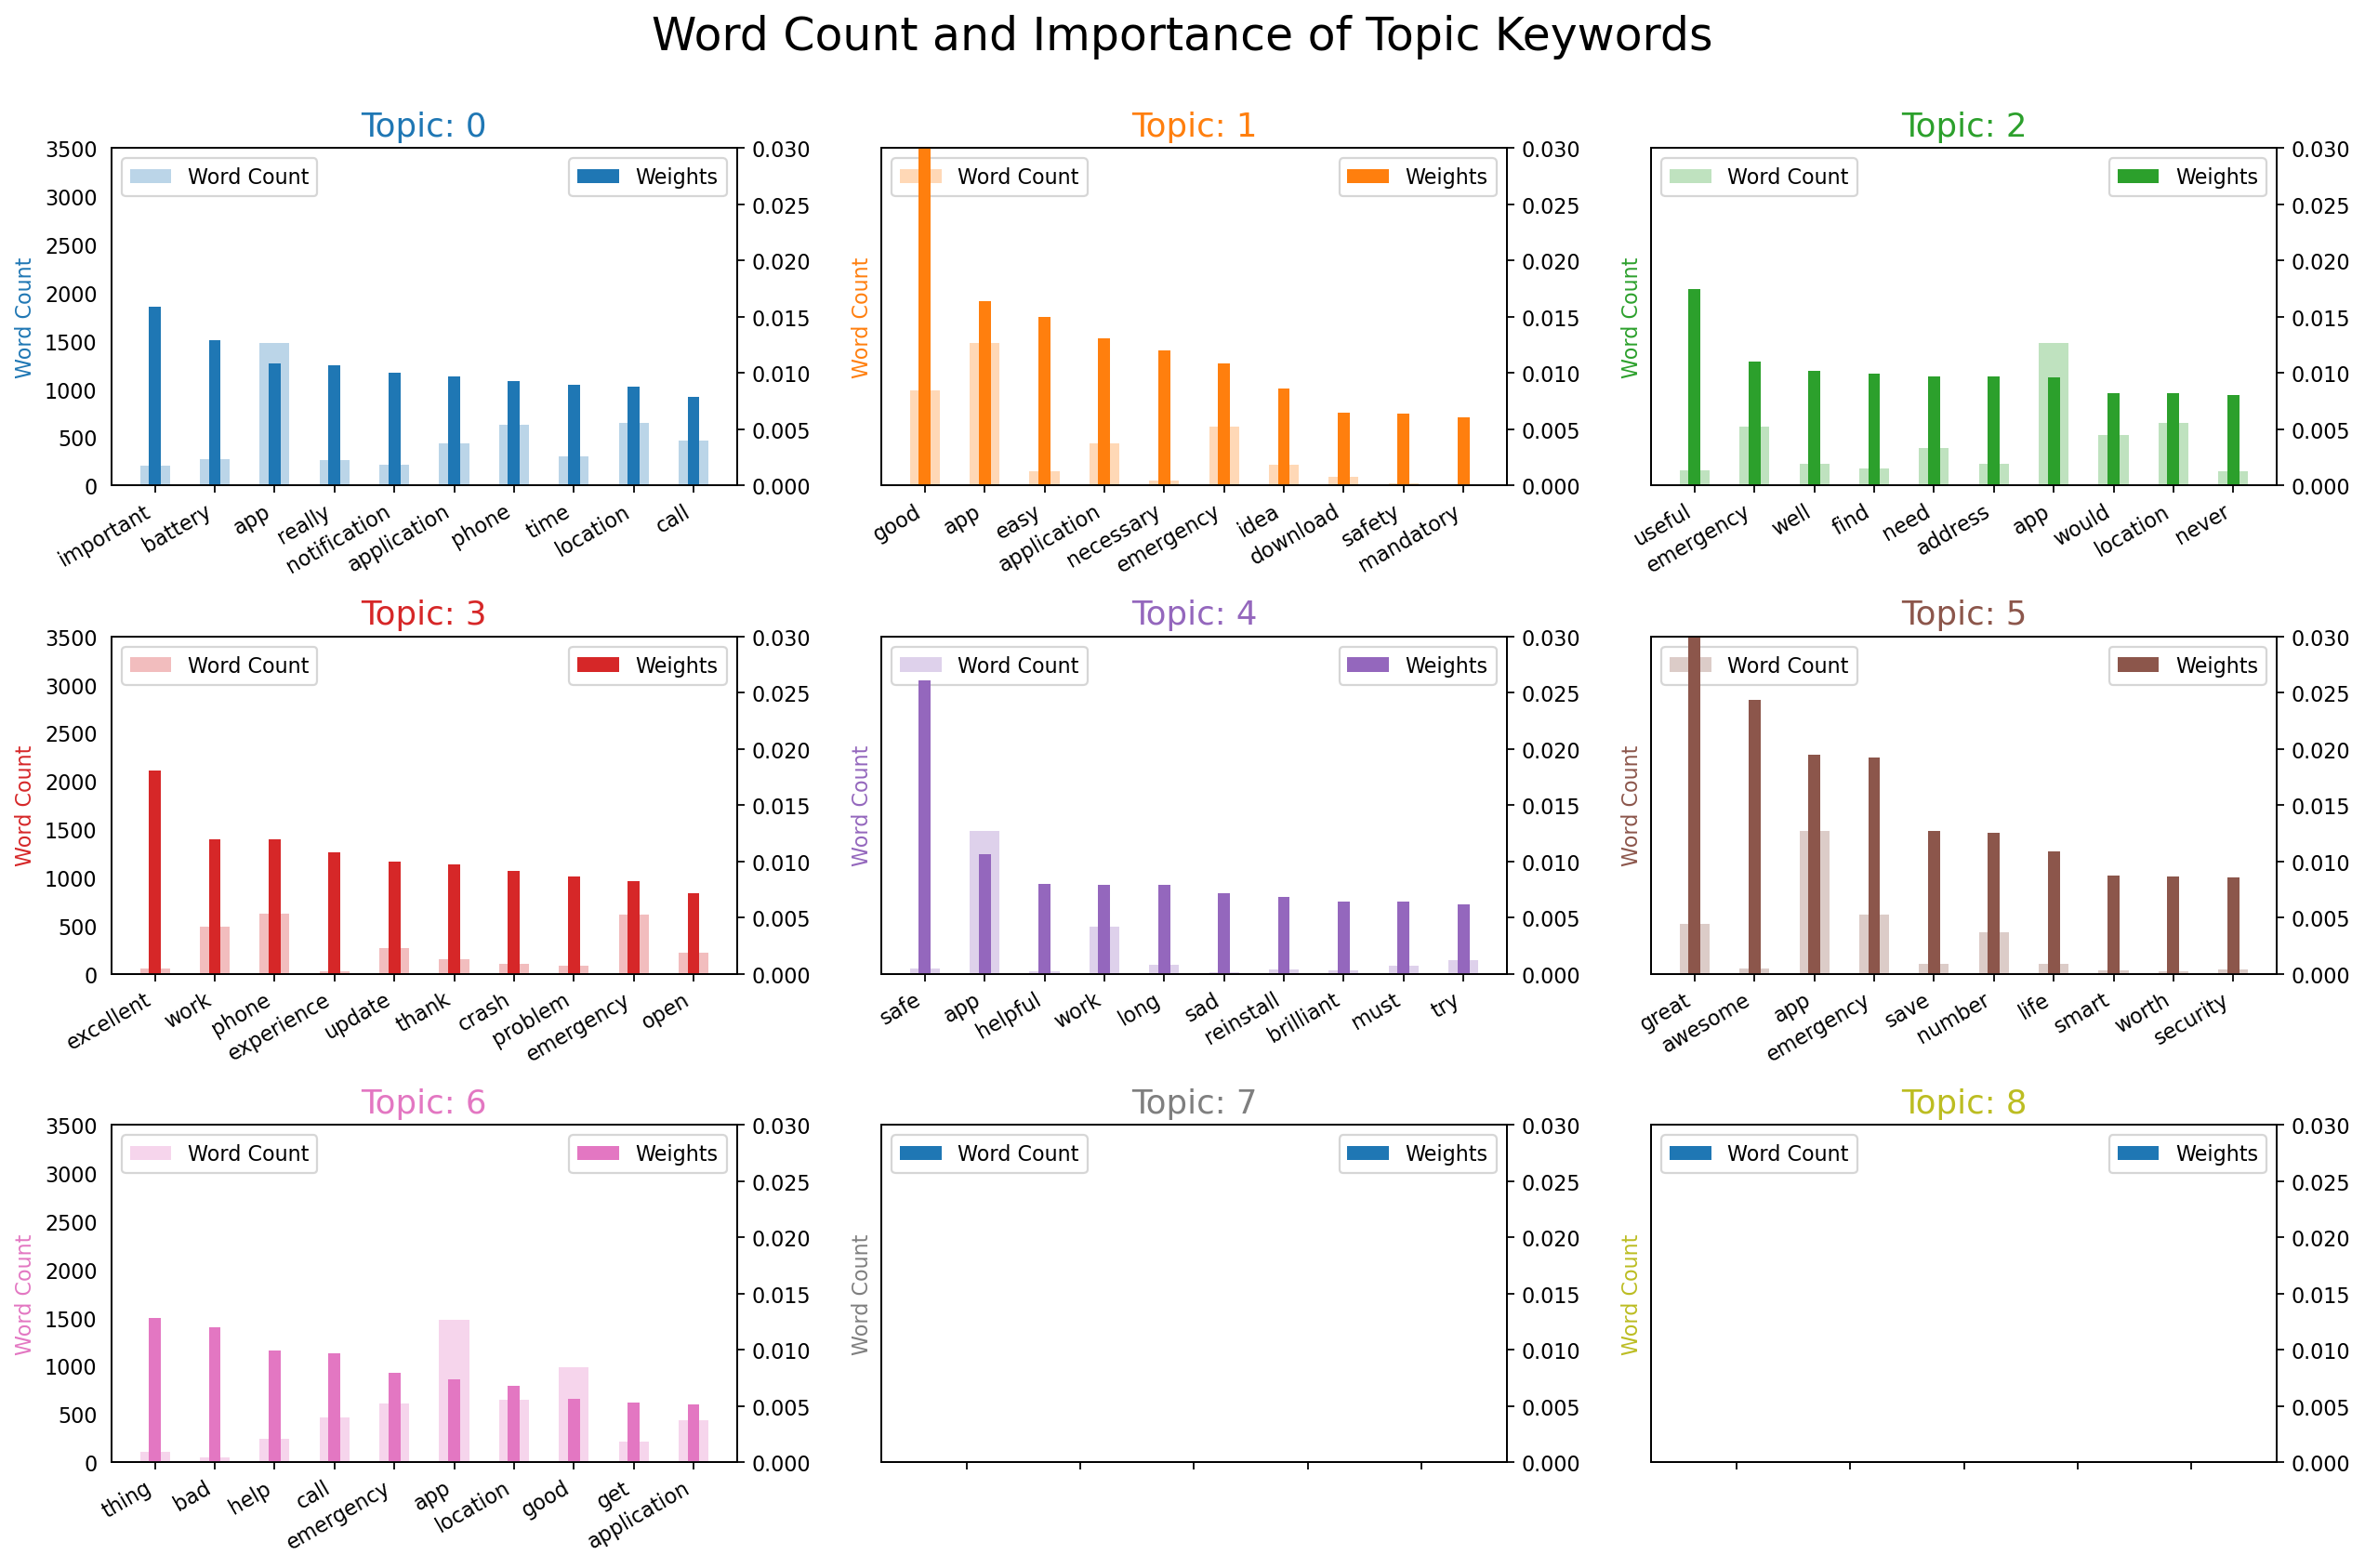

In [30]:
from collections import Counter
topics = ldaModelTfIdf.show_topics(formatted=False)
data_flat = [w for w_list in lemmatizedData for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

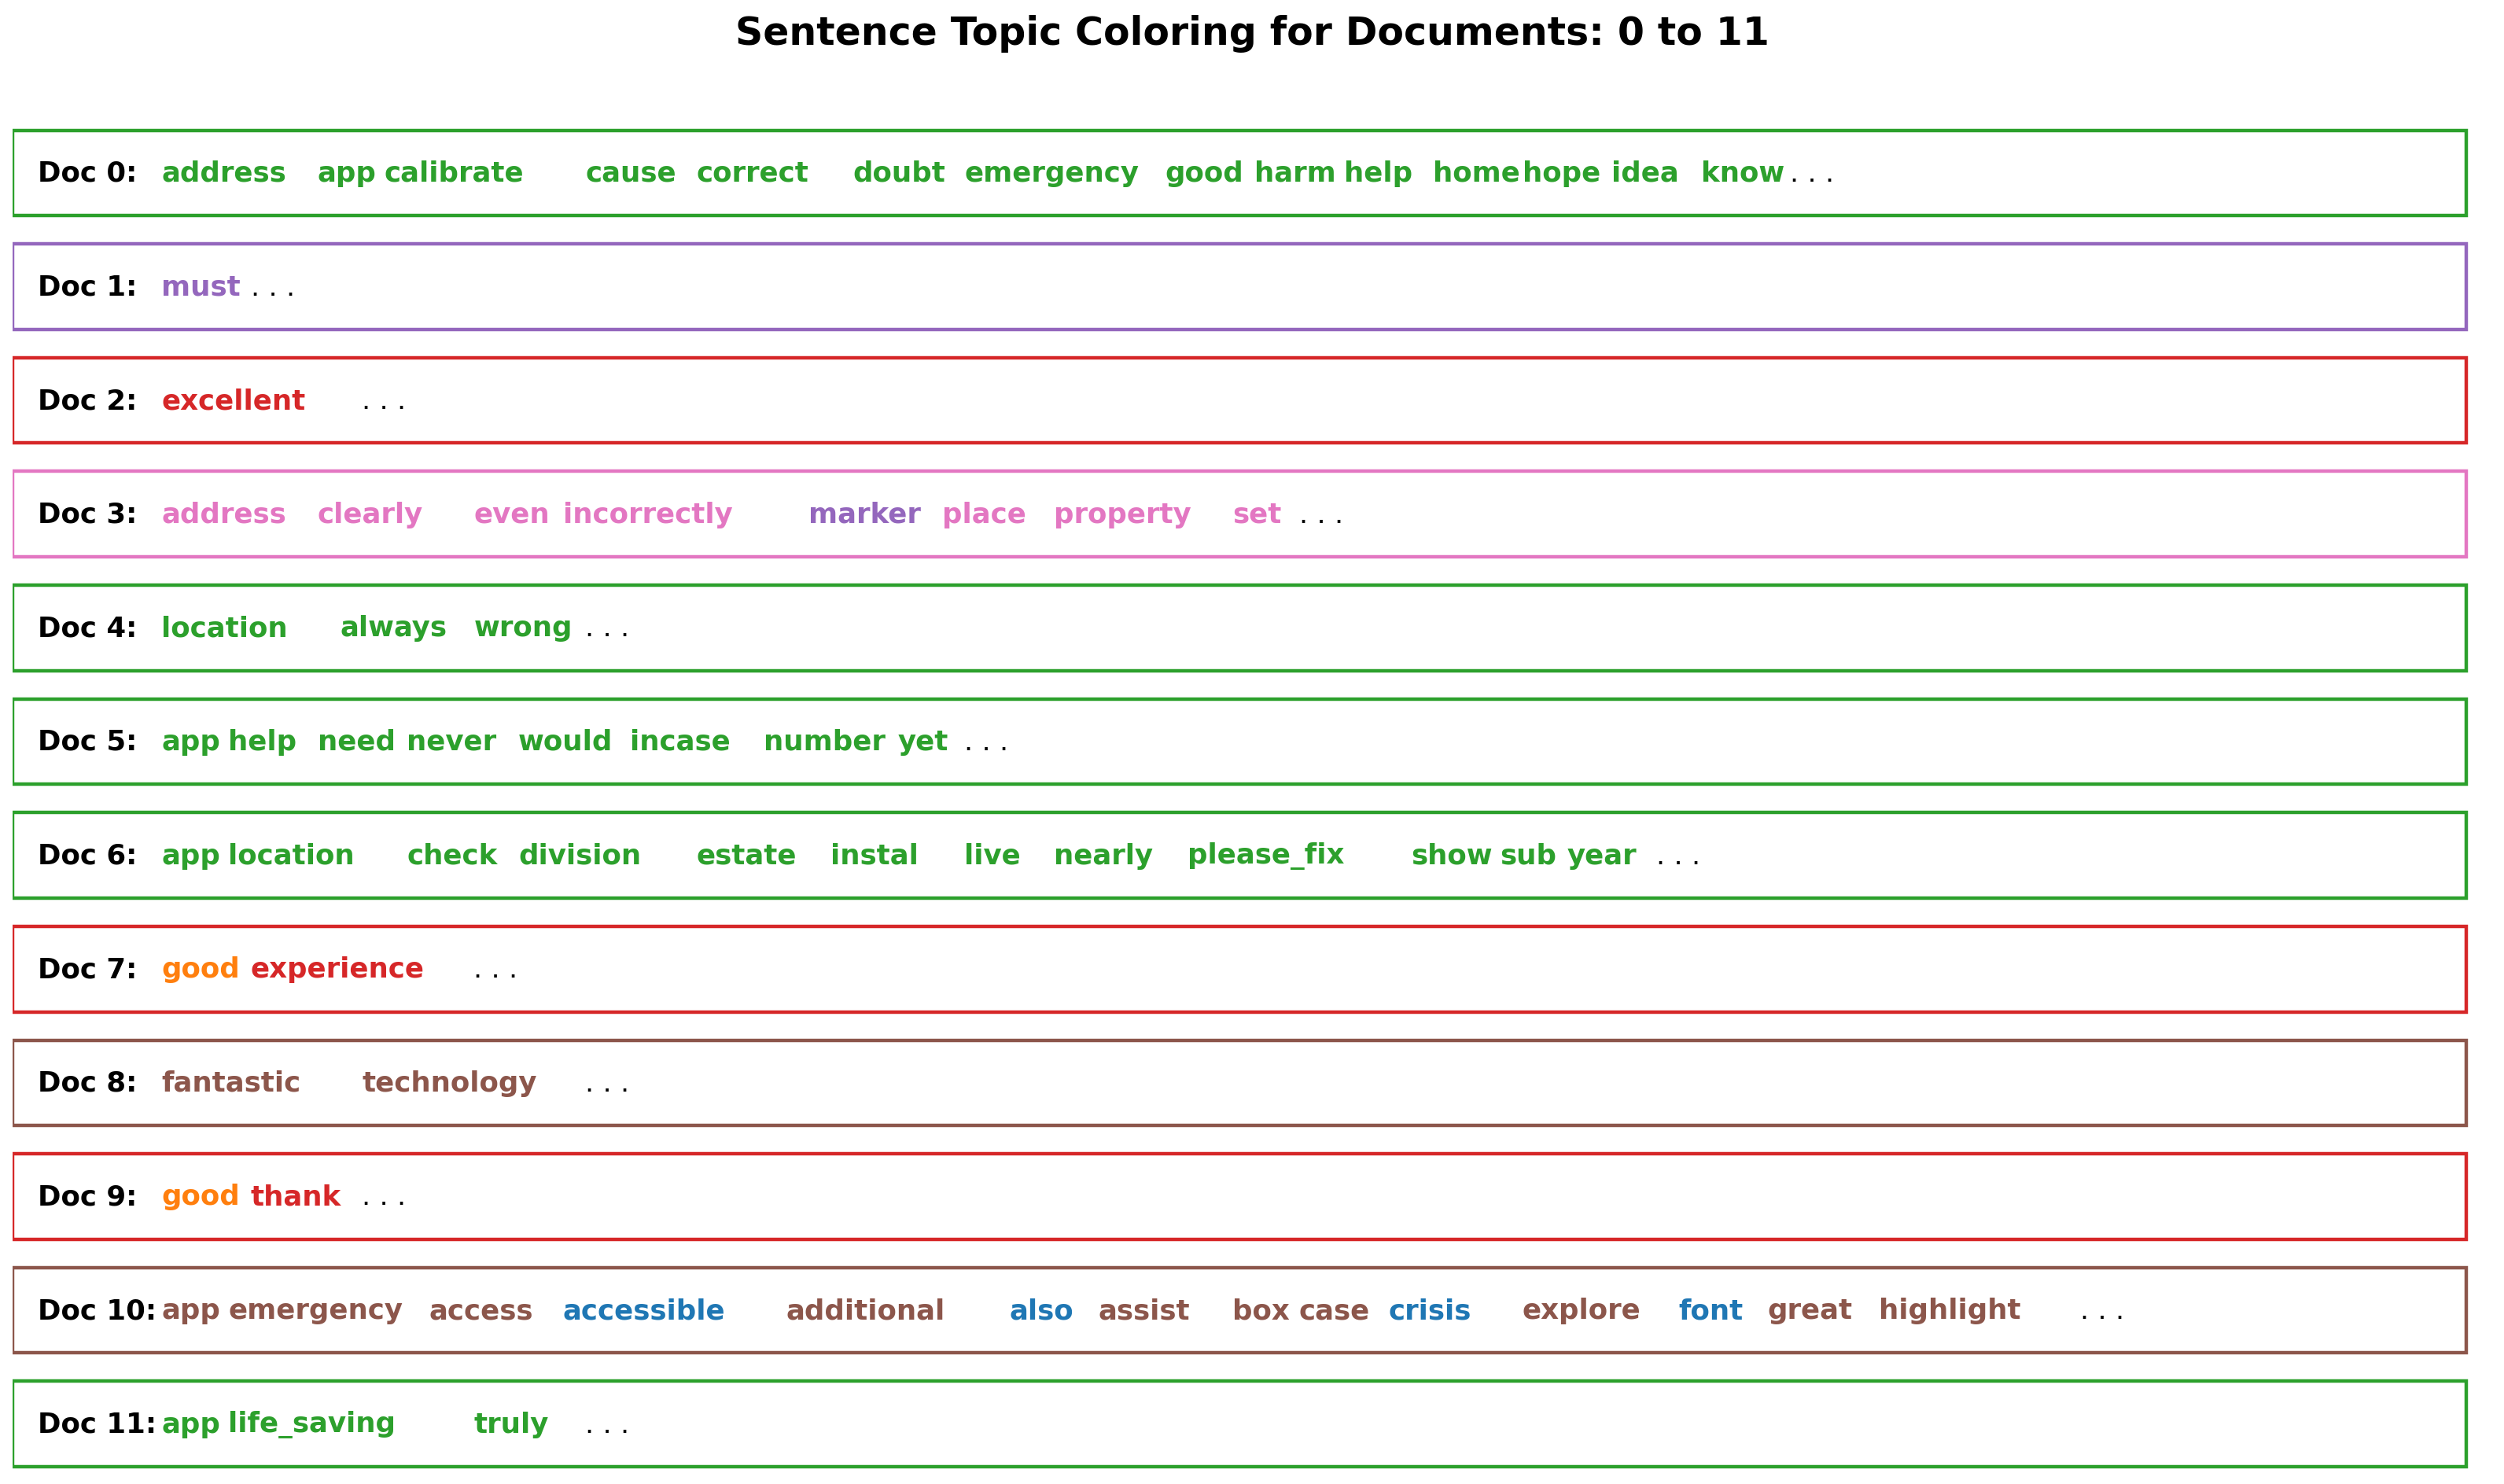

In [32]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=ldaModelTfIdf, corpus=corpusTfidf, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [36]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=ldaModelTfIdf, corpus=corpusTfidf, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in ldaModelTfIdf.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

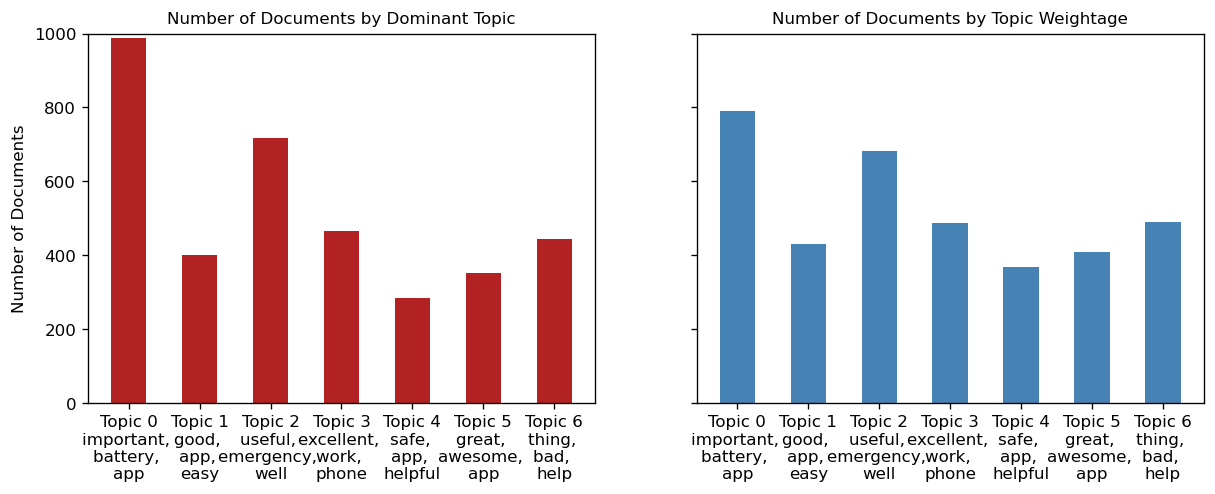

In [38]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [41]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(ldaModelTfIdf[corpusTfidf]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3539 samples in 0.011s...
[t-SNE] Computed neighbors for 3539 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3539
[t-SNE] Computed conditional probabilities for sample 2000 / 3539
[t-SNE] Computed conditional probabilities for sample 3000 / 3539
[t-SNE] Computed conditional probabilities for sample 3539 / 3539
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.690342
[t-SNE] KL divergence after 1000 iterations: 0.323239


Loading BokehJS ...